# First attempt for training model

----

In this code, we'll try to train a model so it can correctly diagnose cancer in input images

## Prerequisites

We'll first configure the logging options an imports

In [1]:
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='INFO'

import logging

logging.basicConfig(level=logging.INFO)

# Get the root logger and set its level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
from src.handlers import Handler, TciaHandler, OpHandler

import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, PersistentDataset, Dataset, pad_list_data_collate
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    ScaleIntensityRanged
)
# from monai.utils import set_determinism


/home/studio-lab-user/.conda/envs/monai-conda/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


### Variable configuration

make sure to provide here all the needed information for file locations

In [4]:
BASE_PATH = 'Data/'
# ...
TCIA_IMG_SUFFIX = '_PV.nii.gz'
TCIA_LOCATION = BASE_PATH + 'TCIA/'
TCIA_EXCEL_NAME = 'HCC-TACE-Seg_clinical_data-V2.xlsx'
# ...
OP_LOCATION = BASE_PATH + 'OP/'
NIFTI_PATH = 'OP_C+P_nifti'
NNU_NET_PATH = 'OP_C+P_nnUnet'
OP_EXCEL = 'OP_申請建模_1121110_20231223.xlsx'
OP_IMG_SUFFIX = '_VENOUS_PHASE.nii.gz'
OP_MASK_SUFFIX = '_VENOUS_PHASE_seg.nii.gz'
OP_ID_COL_NAME = 'OP_C+P_Tumor識別碼'


## File preparation

In this step we're gonna read the excel files and extract the filepaths

In [5]:
global_handler = Handler()

tcia = TciaHandler(TCIA_LOCATION, TCIA_IMG_SUFFIX, TCIA_EXCEL_NAME)
global_handler.add_source(tcia)

op = OpHandler(OP_LOCATION, NIFTI_PATH, NNU_NET_PATH, OP_IMG_SUFFIX, OP_MASK_SUFFIX, OP_EXCEL, OP_ID_COL_NAME)
global_handler.add_source(op)

DEBUG:src.handlers:reading file...
INFO:src.handlers:105 rows in the excel file
INFO:src.handlers:Removed 3 stage-d elements
DEBUG:src.handlers:Classifying...
DEBUG:src.handlers:Looking for paths against contents
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_011_PV.nii.gz
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_031_PV.nii.gz
DEBUG:src.handlers:File not found: Data/TCIA/TCIA_image_PV/HCC_082_PV.nii.gz
DEBUG:src.handlers:None
DEBUG:src.handlers:reading file Data/OP/OP_申請建模_1121110_20231223.xlsx
INFO:src.handlers:200 rows in the excel file
INFO:src.handlers:Removed 55 stage-d elements
DEBUG:src.handlers:Classifying...
DEBUG:src.handlers:Looking for paths against contents
DEBUG:src.handlers:Searching for mismatch on files vs excel data...
DEBUG:src.handlers:Returning new dataframe
DEBUG:src.handlers:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   99 non-null     object
 1   img     99 non-null     object
 2   mask    99 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   244 non-null    object
 1   img     244 non-null    object
 2   mask    244 non-null    object
dtypes: object(3)
memory usage: 5.8+ KB


In [6]:
df = global_handler.df

df.head()

,class,img,mask
0,0,Data/TCIA/TCIA_image_PV/HCC_001_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_001_PV.nii.gz
1,2,Data/TCIA/TCIA_image_PV/HCC_002_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_002_PV.nii.gz
2,2,Data/TCIA/TCIA_image_PV/HCC_003_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_003_PV.nii.gz
3,1,Data/TCIA/TCIA_image_PV/HCC_004_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_004_PV.nii.gz
4,2,Data/TCIA/TCIA_image_PV/HCC_005_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_005_PV.nii.gz


## Data segmentation

Now, we'll split the data into several groups: Train, test and validation

In [7]:
# Calculate sizes
total_samples = len(df)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)

In [25]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df,
    df['class'],
    shuffle=True,
    train_size=train_size,
    random_state=8,
    stratify=df['class']
)


In [9]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    shuffle=True,
    test_size=val_size,
    random_state=8,
    stratify=y_temp
)

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(
    df,
    df['class'],
    shuffle=True,
    test_size=0.4,
    random_state=8,
    stratify=df['class']
)

In [11]:
pd.DataFrame({
    'train': y_train.value_counts(),
    'test': y_test.value_counts(),
    'val': y_val.value_counts(),
})

,train,test,val
class,,,
0.0,52,35,18
2,47,32,16
1.0,47,31,16


In [26]:
X_train

,class,img,mask
15,2,Data/TCIA/TCIA_image_PV/HCC_018_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_018_PV.nii.gz
199,0.0,Data/OP/OP_C+P_nifti/OP_0232_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0232_VENOUS_PHASE_seg...
5,2,Data/TCIA/TCIA_image_PV/HCC_006_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_006_PV.nii.gz
135,0.0,Data/OP/OP_C+P_nifti/OP_0122_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0122_VENOUS_PHASE_seg...
24,2,Data/TCIA/TCIA_image_PV/HCC_027_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_027_PV.nii.gz
...,...,...,...
71,2,Data/TCIA/TCIA_image_PV/HCC_077_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_077_PV.nii.gz
93,1,Data/TCIA/TCIA_image_PV/HCC_100_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_100_PV.nii.gz
49,0,Data/TCIA/TCIA_image_PV/HCC_055_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_055_PV.nii.gz
174,0.0,Data/OP/OP_C+P_nifti/OP_0188_VENOUS_PHASE.nii.gz,Data/OP/OP_C+P_nnUnet/OP_0188_VENOUS_PHASE_seg...


### Data exploration

here it comes a bit of data exploration. You might ommit these steps

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


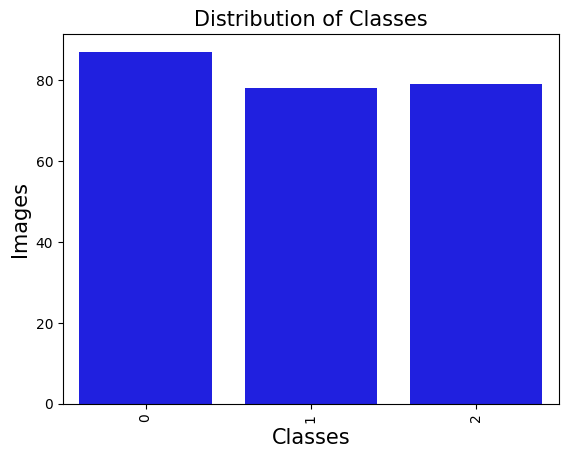

In [9]:
dist = df['class'].value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


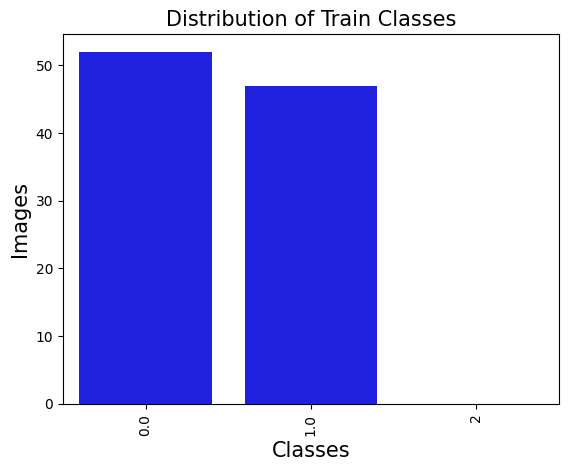

In [10]:
dist = y_train.value_counts()
class_num = len(dist)
sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of Train Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


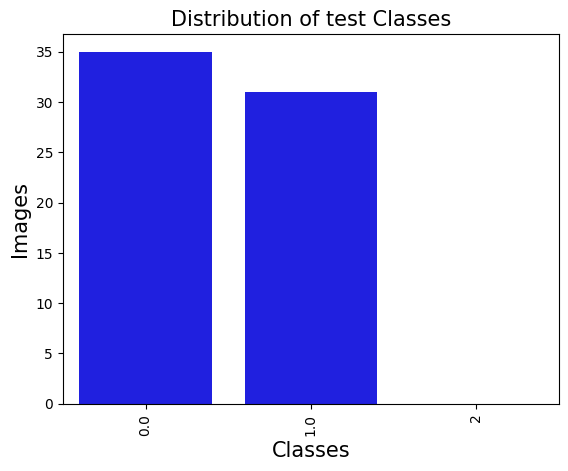

In [11]:
dist = y_test.value_counts()

sns.barplot(x=dist.index, y=dist.values, color='b')
plt.title('Distribution of test Classes', fontsize=15)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Images', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [12]:
len(y_test) + len(y_train)

244

## Model training

Now we might start with the fun part!

### Meta information

Info and config for monai libraries

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [14]:
print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/.conda/envs/monai-conda/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.4
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.15.0
pynrrd version: 1.0.0
clearml version: 1.16.3rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [15]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


### Monai objects

Config of transformations, dataset and dataloader

In [32]:
# TODO: Remove "head"

train_dict = X_train.head().to_dict(orient='records')
test_dict = X_test.head().to_dict(orient='records')
val_dict = X_val.head().to_dict(orient='records')

ds_keys = list(train_dict[0].keys())[-2:]
print(ds_keys)

train_dict

['img', 'mask']


[{'class': 2,
  'img': 'Data/TCIA/TCIA_image_PV/HCC_018_PV.nii.gz',
  'mask': 'Data/TCIA/TCIA_results_phase_PV/HCC_018_PV.nii.gz'},
 {'class': 0.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0232_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0232_VENOUS_PHASE_seg.nii.gz'},
 {'class': 2,
  'img': 'Data/TCIA/TCIA_image_PV/HCC_006_PV.nii.gz',
  'mask': 'Data/TCIA/TCIA_results_phase_PV/HCC_006_PV.nii.gz'},
 {'class': 0.0,
  'img': 'Data/OP/OP_C+P_nifti/OP_0122_VENOUS_PHASE.nii.gz',
  'mask': 'Data/OP/OP_C+P_nnUnet/OP_0122_VENOUS_PHASE_seg.nii.gz'},
 {'class': 2,
  'img': 'Data/TCIA/TCIA_image_PV/HCC_027_PV.nii.gz',
  'mask': 'Data/TCIA/TCIA_results_phase_PV/HCC_027_PV.nii.gz'}]

In the following scenarios, please change the dataset accordingly:

- Use `CacheDataset` when there are no memory constraints (that means, more than 16gb)
- Use `PersistentDatset` when there are no disk constraints (consider the dataset itself is about 5gb)
- Use `Dataset` when there are disk and memory constraints

In [33]:
train_transforms = Compose([
    LoadImaged(keys=ds_keys),
    EnsureChannelFirstd(keys=ds_keys),
    Orientationd(keys=ds_keys, axcodes="PLI"),
    ScaleIntensityRanged(keys=[ds_keys[0]], a_min=-135, a_max=215, b_min=0.0, b_max=1.0, clip=True),
])

train_ds = Dataset(
    data=train_dict,
    transform=train_transforms,
    cache_rate=1.0,
    num_workers=1
)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate
)

Loading dataset: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


In [18]:
test_transforms = Compose([
    LoadImaged(keys=ds_keys),
    EnsureChannelFirstd(keys=ds_keys),
    Orientationd(keys=ds_keys, axcodes="PLI"),
    ScaleIntensityRanged(keys=[ds_keys[0]], a_min=-135, a_max=215, b_min=0.0, b_max=1.0, clip=True),
])

test_ds = Dataset(
    data=test_dict,
    transform=test_transforms,
    cache_rate=1.0,
    num_workers=1
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate
)

Loading dataset: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


### Model training

In [19]:
# temporal model import
from monai.networks.nets.densenet import densenet121
from torch.amp import GradScaler, autocast


In [20]:
model = densenet121(spatial_dims=3, in_channels=1, out_channels=3).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Mixed precision setup
scaler = GradScaler(device.type)


In [22]:
# Start typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 5
accumulation_steps = 4  # Number of steps to accumulate gradients

In [ ]:
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    optimizer.zero_grad()
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[ds_keys[0]].to(device), batch_data["class"].to(device)
        
        with autocast(device.type):
            # For preventing an error of "not double implemented"
            inputs = inputs.float()
            labels = labels.long()
            
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        
        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Clear CUDA cache
        cuda.empty_cache()
        
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    # end for batch_data in train_loader
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        
        num_correct = 0.0
        metric_count = 0
        
        with torch.no_grad():
            for val_data in test_loader:
                val_images, val_labels = val_data[ds_keys[0]].to(device), val_data["class"].to(device)
            # end for in test_loader
        # end with torch.no_grad()
    # end if val_interval == 0
# end for epoch in range

----------
epoch 1/5
1/5, train_loss: 1.3232
2/5, train_loss: 1.1889


# Please ignore this

---

In [ ]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=class_num)])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [ ]:
train_ds = MedNISTDataset(X_train, y_train, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=2)

In [ ]:
val_ds = MedNISTDataset(X_test, y_test, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=2)

In [ ]:
test_ds = MedNISTDataset(X_test, y_test, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=class_num).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()